# Superstore Dataset
## Progetto Data Science 2022 - Brocchi Martina

Il dataset superstore contiene i dati relativi alle vendite effettuate da un superstore all'interno degli Stati Uniti.
A ogni ordine sono associate informazioni riguardanti il cliente, la destinazione dell'ordine e i prodotti acquistati (ad esempio la loro categoria, la quantità e i profitti derivati dalla vendita del prodotto).

### Obiettivo: identificare le migliori strategie di vendita per il superstore
* Analizzare le vendite e i profitti del superstore
* Identificare le categorie e le sotto-categorie di prodotti più vendute e quelle con i maggiori profitti
* Identificare le regioni e i paesi da cui derivano i profitti maggiori
* Identificare la categoria di clienti e la modalità di spedizione ideale per i profitti dell'azienda
* Analizzare l'andamento delle vendite nel tempo

In [1]:
from matplotlib import pyplot as plt
import scipy.stats as stats
import pandas as pd
import pycountry
import plotly.express as px
import seaborn as sns
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Import dataset e analisi caratteristiche
Per prima cosa andiamo a importare il dataset e analizziamo alcune sue caratteristiche principali.

In [2]:
superstore = pd.read_csv('Sample-Superstore.csv', encoding='ISO-8859-1')
superstore.shape

(9994, 21)

In [3]:
superstore.head()

Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10001798        Furniture    Bookcases   
1       42420   South  FUR-CH-10000454        Furniture       Chairs   
2       90036    West  OFF-LA-10000240  Office Supplies       Labels   
3       33311   South  FUR-TA-10000577        Furniture       Tables   
4       33311   South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400         3   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200         2   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775         5   
4                     Eldon Fold 'N Roll Cart System   22.3680         2   

   Discount    Profit  
0      0.00   41.9136  
1      0.00  219.5820  
2      0.00    6.8714  
3      0.45 -383.0310  
4      0.20    2.5164  

[5 rows x 21 columns]

Andiamo a suddividere features qualitative e features quantitative e andiamo a utilizzare la funzione describe per ottenere informazioni su di esse.

In [4]:
superstore_quantitative = superstore[['Row ID','Postal Code', 'Sales', 'Quantity', 'Discount', 'Profit']]
superstore_qualitative = superstore[['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name']]
superstore_quantitative.describe()

Row ID   Postal Code         Sales     Quantity     Discount  \
count  9994.000000   9994.000000   9994.000000  9994.000000  9994.000000   
mean   4997.500000  55190.379428    229.858001     3.789574     0.156203   
std    2885.163629  32063.693350    623.245101     2.225110     0.206452   
min       1.000000   1040.000000      0.444000     1.000000     0.000000   
25%    2499.250000  23223.000000     17.280000     2.000000     0.000000   
50%    4997.500000  56430.500000     54.490000     3.000000     0.200000   
75%    7495.750000  90008.000000    209.940000     5.000000     0.200000   
max    9994.000000  99301.000000  22638.480000    14.000000     0.800000   

            Profit  
count  9994.000000  
mean     28.656896  
std     234.260108  
min   -6599.978000  
25%       1.728750  
50%       8.666500  
75%      29.364000  
max    8399.976000

In [5]:
superstore_qualitative.describe()

Order ID Order Date   Ship Date       Ship Mode Customer ID  \
count             9994       9994        9994            9994        9994   
unique            5009       1237        1334               4         793   
top     CA-2017-100111   9/5/2016  12/16/2015  Standard Class    WB-21850   
freq                14         38          35            5968          37   

        Customer Name   Segment        Country           City       State  \
count            9994      9994           9994           9994        9994   
unique            793         3              1            531          49   
top     William Brown  Consumer  United States  New York City  California   
freq               37      5191           9994            915        2001   

       Region       Product ID         Category Sub-Category     Product Name  
count    9994             9994             9994         9994             9994  
unique      4             1862                3           17             1850  
top      West  OFF-PA-10001970  Office Supplies      Binders  Staple envelope  
freq     3203               19             6026         1523               48

In [6]:
print(superstore['Category'].unique())

['Furniture' 'Office Supplies' 'Technology']


Dall'analisi delle features qualitative possiamo evincere come il dataset contenga informazioni su 5009 ordini, effettuati per 793 clienti diversi. Tutti gli ordini sono stati inviati negli Stati Uniti, con una maggiore frequenza nell'ovest del paese, in particolare in California.

Le categorie di prodotti spediti sono tre: Technology, Office Supplies, Furniture

Inoltre, come possiamo osservare dai valori della riga count di entrambe le tabelle ottenute, non abbiamo valori nulli all'interno del dataset. Andiamo a confermare tale osservazione tramite la funzione isnull().

In [7]:
superstore.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

## Analisi vendite e profitti del superstore
Iniziamo l'analisi delle vendite e dei profitti del superstore considerando i prodotti venduti suddivisi per categoria e sotto-categoria.
Per prima cosa andiamo a rappresentare tramite un grafico a barre il totale dei prezzi di vendita e il totale dei profitti per le diverse categorie.

<Figure size 432x288 with 0 Axes>

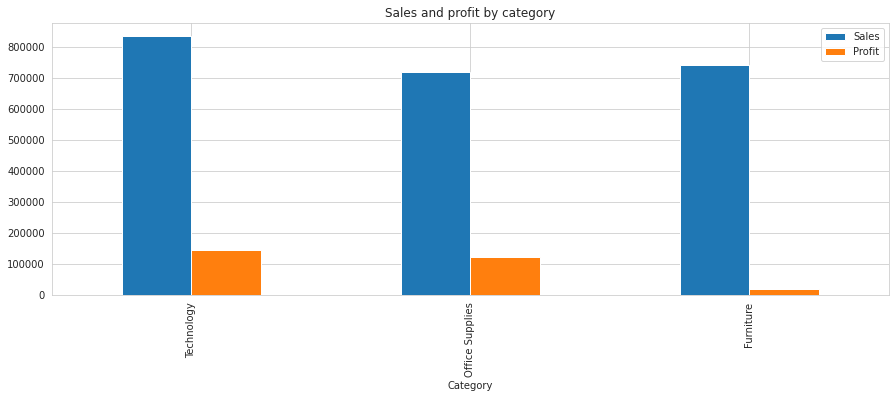

In [8]:
superstore_category = superstore.groupby('Category')[['Sales', 'Profit']].sum().sort_values('Profit', ascending=False)

plt.figure()
superstore_category.plot(kind='bar', figsize=(15,5))
plt.title("Sales and profit by category")
plt.show()

Dal grafico a barre possiamo evincere come le tre categorie di prodotti abbiano un totale di vendite simile, nonostante la categoria di prodotti Technology sia quella con le vendite maggiori.
Tale categoria è anche quella da cui derivano i profitti più alti.

La categoria Furniture ha vendite simili alle altre due, tuttavia da essa derivano i profitti minori.
Tramite il rapporto tra profitto e prezzo di vendita possiamo calcolare il margine di profitto, che indica la percentuale di guadagno dell'azienda rispetto alle spese.

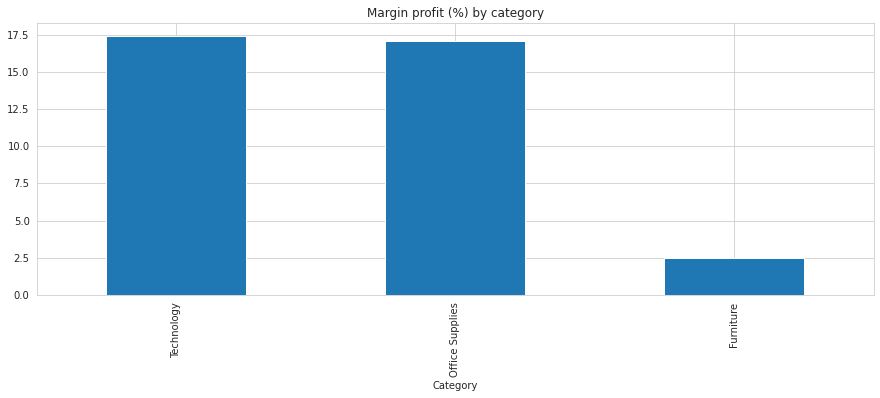

In [9]:
margin_profit_category = np.round(((superstore_category.Profit / superstore_category.Sales) * 100),3)

plt.plot()
margin_profit_category.plot(kind='bar', figsize=(15,5))
plt.title("Margin profit (%) by category")
plt.show()

Le categorie _Technology_ e _Office Supplies_ hanno un margine di profitto dalle vendite pari al 17% circa, mentre la categoria _Furniture_ ha un margine di profitto molto basso, circa pari al 2%.
Andiamo a effettuare la stessa analisi anche per quanto riguarda la suddivisione dei prodotti in sotto-categorie

<Figure size 432x288 with 0 Axes>

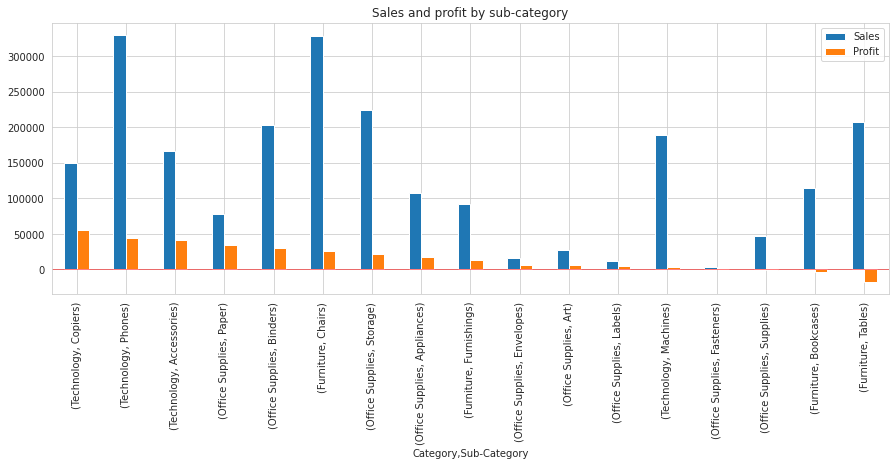

In [10]:
superstore_sub_category = superstore.groupby(['Category','Sub-Category'])[['Sales', 'Profit']].sum()

plt.figure()
superstore_sub_category.sort_values('Profit', ascending=False).plot(kind='bar', figsize=(15,5))
plt.axhline(y=0, color='r', linestyle='-', lw=0.5)
plt.title("Sales and profit by sub-category")
plt.show()

Le sotto-categorie _phones_ e _chairs_ sono quelle con le vendite maggiori. La sotto-categoria _phones_ è anche la seconda con i profitti maggiori, subito dopo alla sotto-categoria _copiers_.
Queste ultime sotto-categorie appartengono entrambe alla categoria _Technology_.

Dal grafico a barre possiamo inoltre notare come ci siano sotto-categorie con profitti nulli, come la sotto-categoria _supplies_, o addirittura negativi, come nel caso delle sotto-categorie _bookcases_ e _tables_. Quest'ultime appartengono entrambe alla categoria _Furniture_, la categoria con i profitti minori.

Le sotto-categorie con le vendite minori appartengono invece tutte alla categoria _Office Supplies_.

Anche in questo caso andiamo a calcolare i valori del margine di profitto

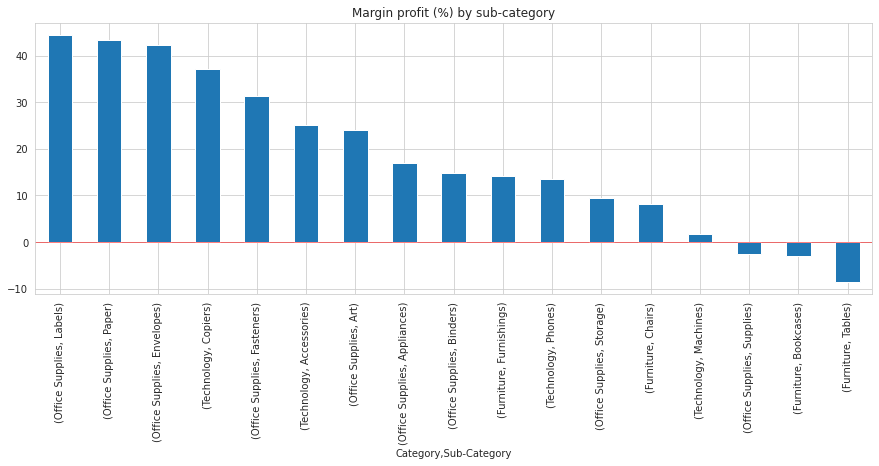

In [11]:
profit_margin_sub_category = np.round(((superstore_sub_category.Profit / superstore_sub_category.Sales) * 100), 3)

plt.figure()
profit_margin_sub_category.sort_values(ascending=False).plot(kind='bar', figsize=(15,5))
plt.axhline(y=0, color='r', linestyle='-', lw=0.5)
plt.title("Margin profit (%) by sub-category")
plt.show()

Nonostante le sotto-categorie appartenenti alla categoria _Office Supplies_ abbiano le vendite minori, il loro margine di profitto è tra i più alti.
Questo poiché i profitti di tali sotto-categorie sono talvolta nulli ma mai negativi, e spesso si avvicinano al valore delle vendite.

Proviamo ora ad analizzare i profitti delle sotto-categorie _phones_ (vendite e profitti maggiori) e _tables_ (profitti e margini di profitto minori) per regione del paese


In [12]:
def profit_subCatByRegion(subCats, n):
    plt.figure()
    for i,subCat in enumerate(subCats):
        plt.subplot(1,n,i+1)
        A = superstore[superstore['Sub-Category'] == subCat]
        A.groupby('Region')['Profit'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(40,10))
        plt.axhline(y=0, color='r', linestyle='-', lw=1)
        plt.title("Profit by region in the sub-category of "+subCat)
    plt.show()

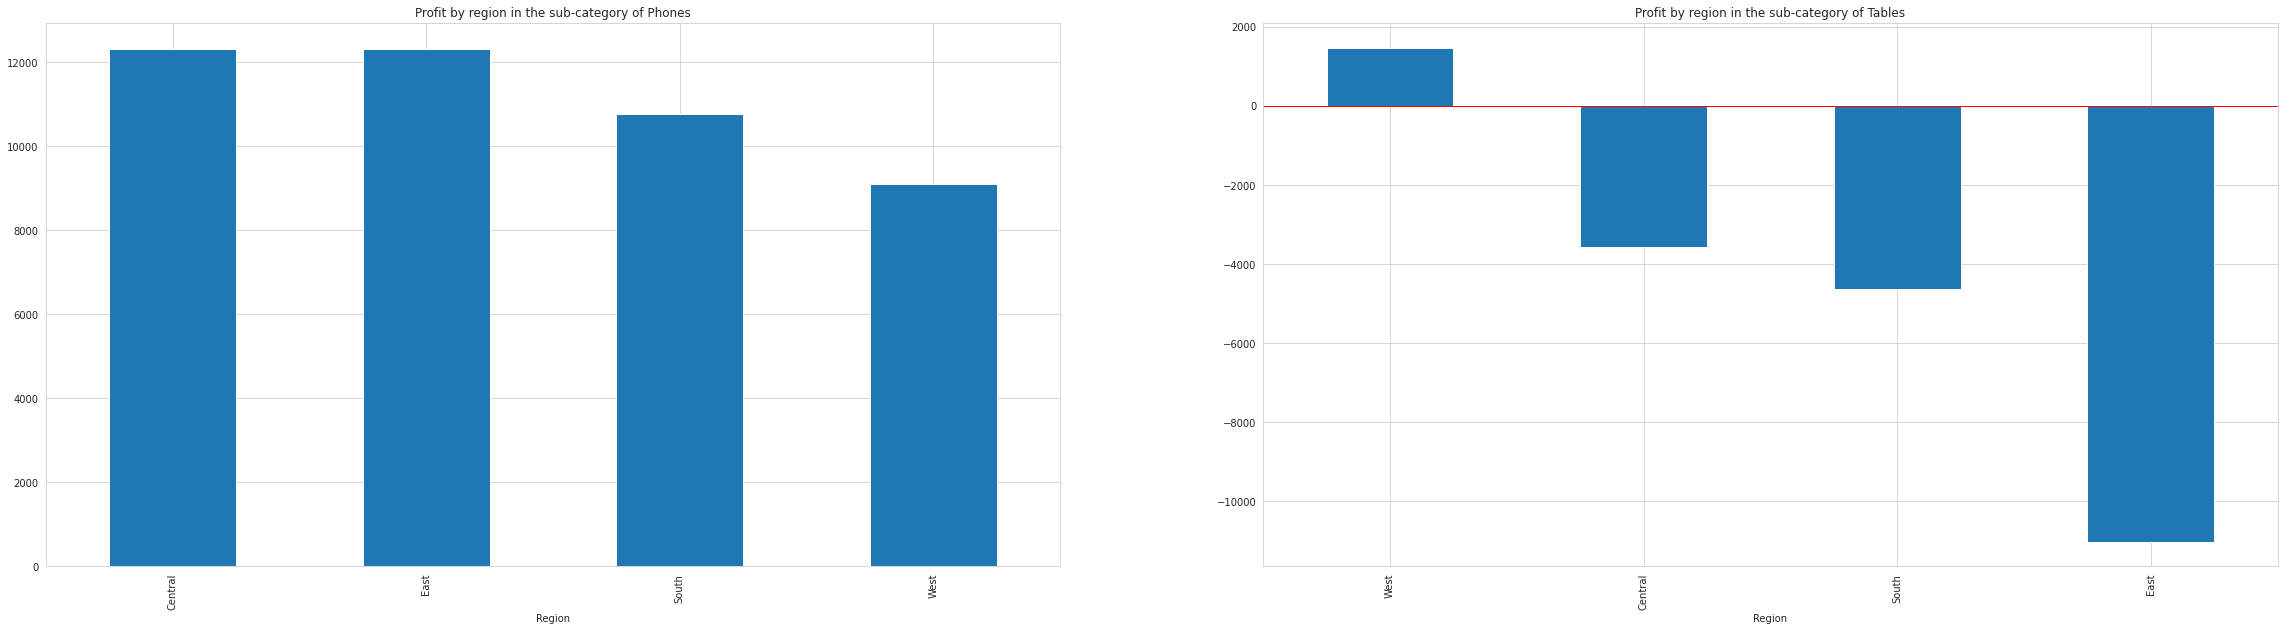

In [13]:
subCats = ['Phones','Tables']
profit_subCatByRegion(subCats, len(subCats))

Come possiamo osservare le perdite maggiori nella sotto-categoria _tables_ derivano dalle vendite effettuate nell'est del paese, mentre l'unica regione che ha portato dei profitti è quella dell'ovest del paese.
Tuttavia, nel caso della sotto-categoria _phones_ dall'ovest del paese derivano i profitti minori.

Queste osservazioni ci portano a formulare una domanda: la distribuzione dei profitti per categoria varia all'interno delle diverse regioni degli Stati Uniti?

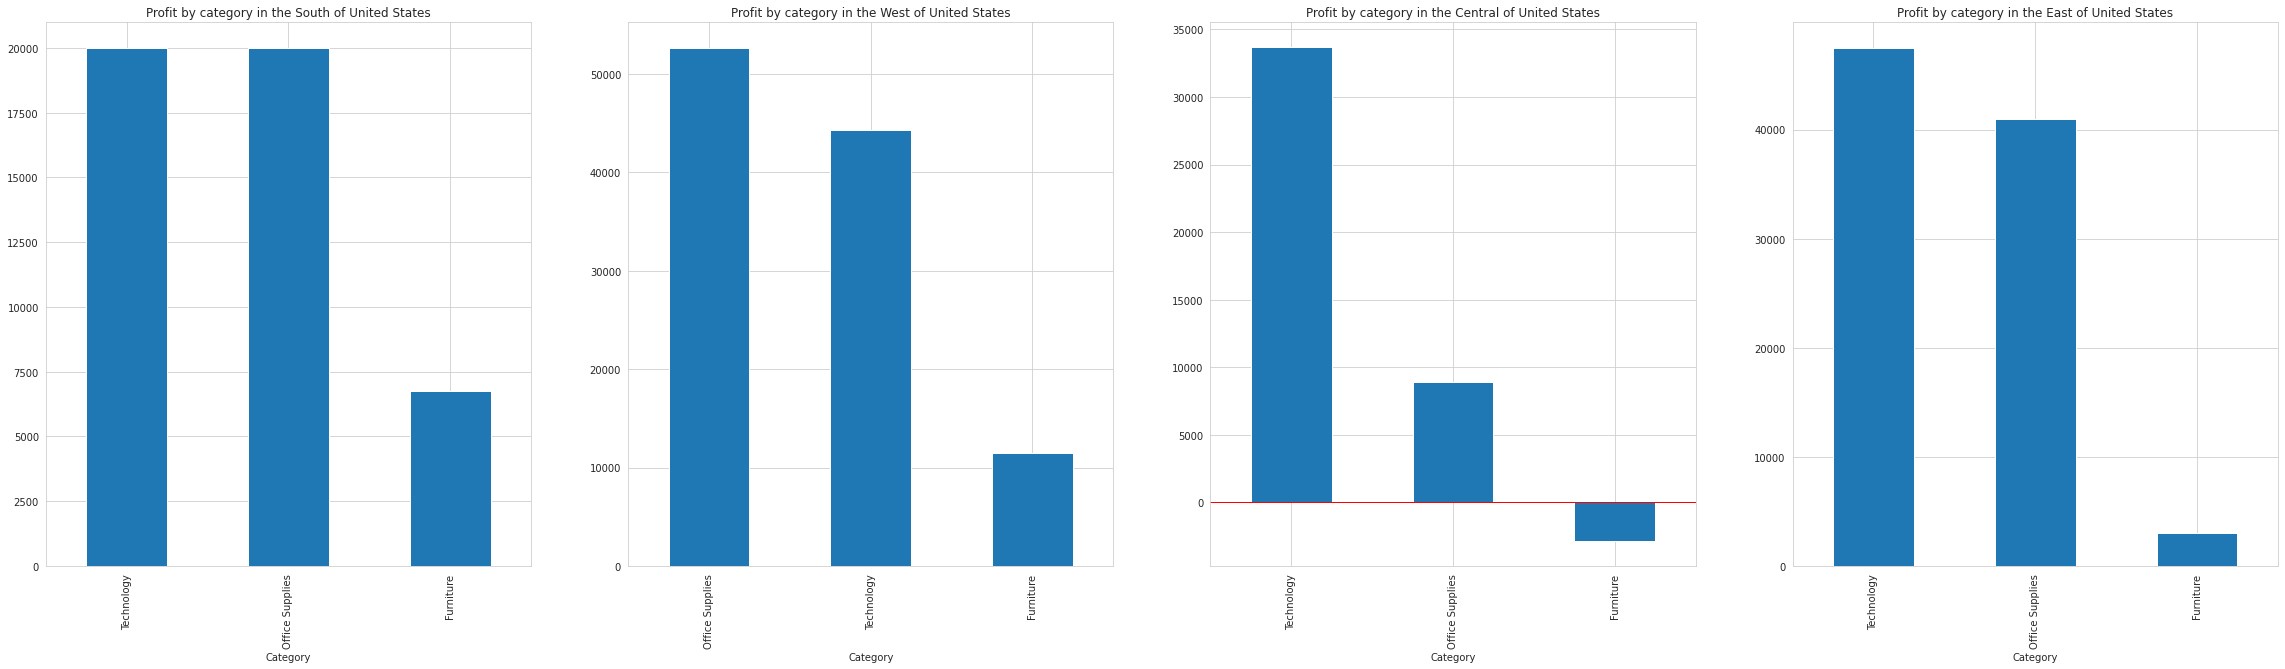

In [14]:
plt.figure()
for i,reg in enumerate(superstore['Region'].unique()):
    A = superstore[superstore['Region'] == reg].groupby('Category')['Profit'].sum()
    plt.subplot(1,4,i+1)
    A.sort_values(ascending=False).plot(kind='bar', figsize=(40,10))
    plt.axhline(y=0, color='r', linestyle='-', lw=1)
    plt.title("Profit by category in the "+reg+" of United States")
plt.show()

Dai grafici è possibile evincere come la categoria _Technology_ sia quella con i profitti maggiori in tutte le regioni eccetto quella dell'ovest degli Stati Uniti, in cui la categoria con i maggiori profitti è _Office Supplies_.

Un'altra osservazione che possiamo ricavare dai profitti delle categorie nelle varie regioni è il valore della somma dei profitti: nel caso dell'ovest la categoria con i maggiori profitti ha un valore che supera 50000 dollari.
Nel caso delle altre regioni i profitti sono più bassi; in particolare nel sud degli Stati Uniti la categoria con i profitti totali maggiori ha un valore di 20000 dollari.
Questo ci porta a pensare che i profitti totali nell'ovest degli Stati Uniti siano più alti di quelle delle altre regioni.

Andiamo ad analizzare i profitti totali per regione degli Stati Uniti.

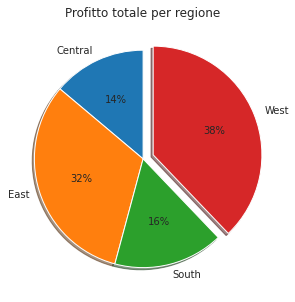

In [15]:
superstore_region = superstore.groupby('Region')['Profit'].sum()

plt.figure(figsize=(15,5))
plt.pie(superstore_region, labels=superstore_region.keys(), startangle = 90, autopct = "%1.0f%%", explode = [0, 0, 0, 0.1], shadow = True)
plt.title("Profitto totale per regione")

plt.show()

La regione con i profitti maggiori è effettivamente quella dell'ovest degli Stati Uniti (38% dei profitti totali), seguita subito dall'est del paese (32% dei profitti totali).
Nella parte centrale e nel sud del paese i profitti sono pressoché dimezzati rispetto alle altre due regioni. Questo potrebbe essere dovuto a una combinazione di due fattori: la presenza di un numero inferiore di ordini in quella regione o la maggiore presenza di ordini con profitti in negativo.

Andiamo più in particolare ad analizzare i profitti per singolo stato, visualizzando i dati tramite una mappa del paese e tramite un grafico a barre.

In [16]:
codes = np.empty_like(superstore['State'])
tot_profit = np.empty_like(superstore['Profit'])

for elem in superstore['State'].unique(): 
    codes[np.where(superstore['State'] == elem)] = pycountry.subdivisions.lookup(elem).code[3:5]
    tot_profit[np.where(superstore['State']==elem)] = superstore.groupby('State')['Profit'].sum().get(elem)

codes[np.where(codes=='12')] = 'MT'
superstore['State Code'] = codes
superstore['Total profit by State'] = tot_profit

fig = px.choropleth(superstore,
                    locations='State Code', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Total profit by State',
                    color_continuous_scale="Viridis_r",
                    )
fig.show()

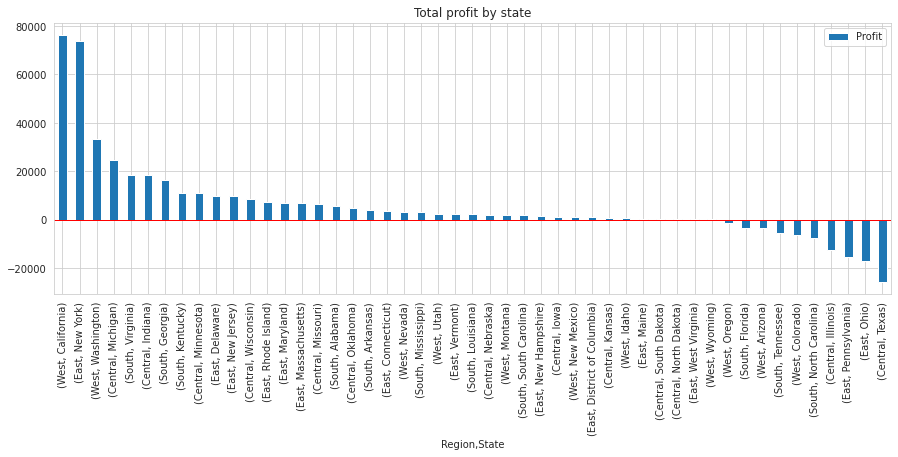

In [17]:
superstore.groupby(['Region', 'State'])[['Profit']].sum().sort_values('Profit', ascending=False).plot(kind='bar', figsize=(15,5))
plt.axhline(y=0, color='r', linestyle='-', lw=1)
plt.title("Total profit by state")
plt.show()

Gli stati da cui deriva il maggior profitto sono California, New York e Washington, che appartengono alle regioni est e ovest del paese.
Le perdite maggiori si verificano in Texas, stato appartenente alla regione centrale degli Stati Uniti.


## Correlazione tra profitto, prezzo di vendita e sconto
Proviamo a cercare una correlazione tra prezzo di vendita, profitto e sconto per capire da cosa possano derivare i profitti negativi.

In [18]:
superstore[['Profit', 'Sales', 'Discount']].corr(method='pearson')

Profit     Sales  Discount
Profit    1.000000  0.479064 -0.219487
Sales     0.479064  1.000000 -0.028190
Discount -0.219487 -0.028190  1.000000

Possiamo notare come esista una correlazione positiva tra il prezzo di vendita e i profitti, mentre esista una correlazione negativa tra lo sconto e i profitti.
Tra il prezzo di vendita e lo sconto esiste una correlazione negativa molto debole, quasi nulla.
Non esiste invece correlazione tra la modalità di spedizione e le altre variabili.

Questo ci fa ipotizzare che lo sconto vada a impattare sui profitti dell'azienda, facendo sì che possano andare anche in negativo.
Questa ipotesi viene confermata dalla correlazione quasi nulla tra sconto e prezzo di vendita: l'applicazione dello sconto non implica un aumento significativo del prezzo di vendita e va a diminuire il margine di profitto dell'azienda.

Proviamo a visualizzare questa tendenza tramite un grafico a dispersione.

### Sales vs Profit

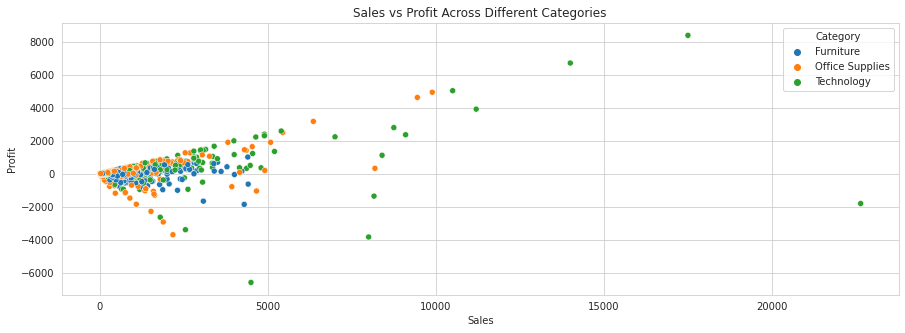

In [19]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=superstore['Sales'], y=superstore['Profit'], hue=superstore['Category'])
plt.title("Sales vs Profit Across Different Categories")
plt.show()

Dal grafico a dispersione possiamo notare come i profitti crescano in modo lineare rispetto ai prezzi di vendita. Esiste tuttavia una parte di profitti che decresce all'aumentare dei prezzi di vendita.

Proviamo ora a utilizzare un modello di regressione lineare per stimare il profitto a partire dal prezzo di vendita dei prodotti, calcolando il corrispondente errore e definendo un modello nullo per avere informazioni sull'errore in caso di random guess.

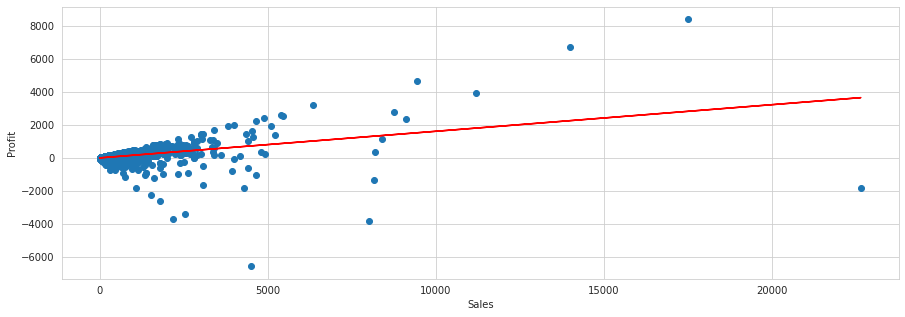

RMSE: 160.897891365734
RMSE null model: 202.1526188782092 



In [20]:
X = superstore[['Sales']]
y = superstore['Profit']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)
reg = LinearRegression().fit(X_train, y_train)

plt.figure(figsize=(15,5))
plt.scatter(X_train, y_train)
plt.plot(np.array(X_train), np.array(reg.coef_*X_train+reg.intercept_), color='r')
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.show()

y_pred = reg.predict(X_valid)
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))

mean_profit = superstore['Profit'].mean()
null_model_y = [mean_profit] * X_valid.shape[0]
print ('RMSE null model:', np.sqrt(metrics.mean_squared_error(y_valid, null_model_y)),'\n')

Dai valori dell'errore quadratico medio del nostro modello e dell'errore quadratico medio del modello nullo possiamo evincere come il nostro modello riesca effettivamente ad approssimare i profitti in base al prezzo di vendita meglio di un modello nullo (basato su una stima casuale - random guess).

Tuttavia il valore dell'errore del nostro modello resta molto alto e abbastanza vicino al valore dell'errore del modello nullo. Inoltre i valori che abbiamo a disposizione sono concentrati sotto un prezzo di vendita di 5000 dollari, mentre oltre tale soglia abbiamo pochi valori; il modello da noi allenato potrebbe quindi essere poco accurato per predire i profitti relativi a un prezzo di vendita superiore a 5000 dollari.

Possiamo quindi concludere che il modello di regressione lineare implementato non sia molto utile per stimare i profitti dell'azienda.

### Discount vs Profit

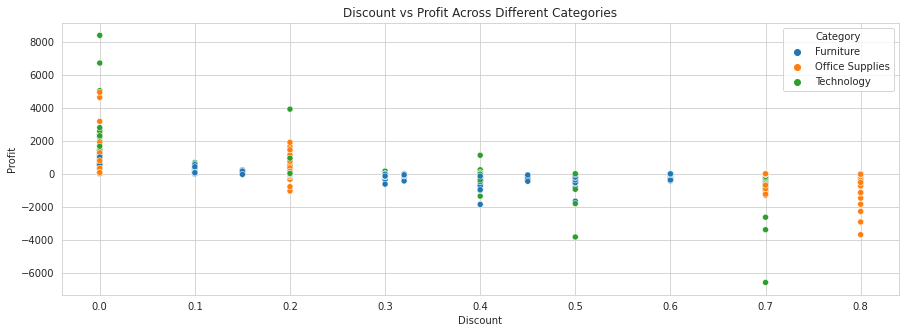

In [21]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=superstore['Discount'], y=superstore['Profit'], hue=superstore['Category'])
plt.title("Discount vs Profit Across Different Categories")
plt.show()

Possiamo osservare come a partire da uno sconto del 45% i profitti siano tutti negativi, ossia che l'azienda vada in perdita. Gli sconti maggiori, pari all'80%, sono applicati a prodotti della categoria _Office Supplies_

## Tipologia di clienti e modalità di spedizione
Una volta stabilita la presenza di una correlazione negativa tra sconti applicati e profitto dell'azienda, cerchiamo di capire se tali sconti siano applicati ad una particolare categoria di clienti o ad una particolare tipologia di spedizioni e quindi se queste abbiano un impatto diverso sui profitti dell'azienda.

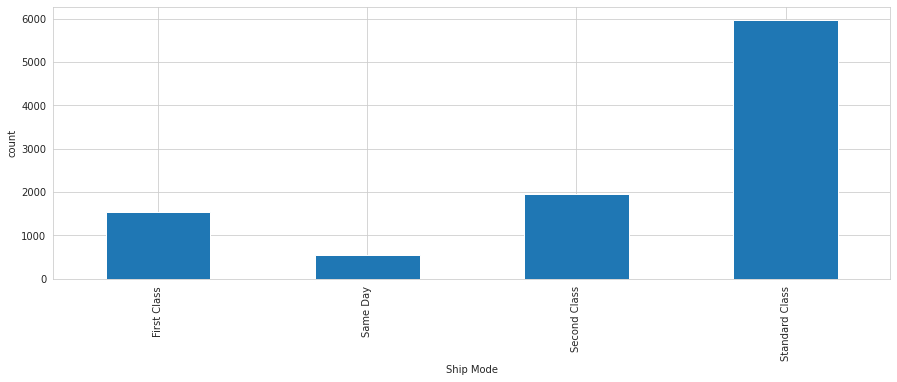

In [22]:
plt.figure()
superstore.groupby('Ship Mode')['Order ID'].count().plot(kind='bar', figsize=(15,5))
plt.ylabel("count")
plt.show()

Esistono 4 tipologie di spedizione. La modalità più popolare è la _Standard Class_, seguita da _Second Class_, _First Class_ e _Same Day_.
Andiamo ad associare a ognuna un valore, che ci permette di calcolare la correlazione con il profitto e lo sconto.

In [23]:
superstore.loc[superstore['Ship Mode'] == 'Same Day', 'Ship Mode' ] = 1
superstore.loc[superstore['Ship Mode'] == 'First Class', 'Ship Mode' ] = 2
superstore.loc[superstore['Ship Mode'] == 'Second Class', 'Ship Mode' ] = 3
superstore.loc[superstore['Ship Mode'] == 'Standard Class', 'Ship Mode' ] = 4
superstore = superstore.astype({'Ship Mode': np.int64})

Effettuiamo la stessa operazione con la tipologia di cliente

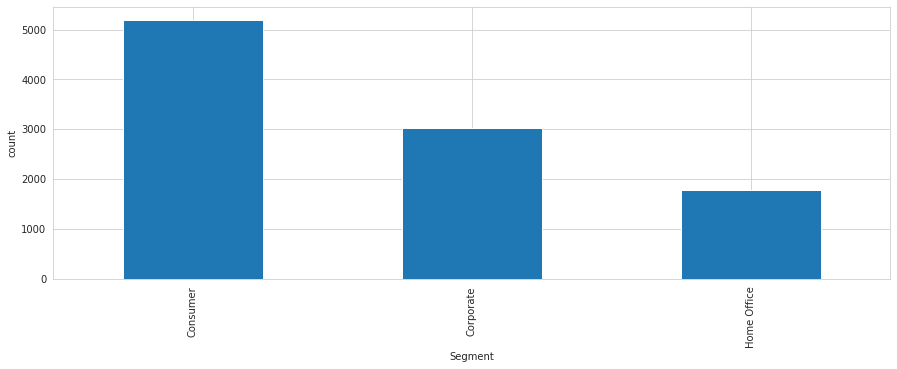

In [24]:
plt.figure()
superstore.groupby('Segment')['Order ID'].count().plot(kind='bar', figsize=(15, 5))
plt.ylabel("count")
plt.show()

Più del 50% delle vendite derivano dai normali consumatori, il 30% derivano dalle aziende mentre la restante parte deriva dalla tipologia di cliente _Home Office_, ossia clienti che acquistano prodotti per lavorare da casa.
Convertiamo anche in questo caso il nome della tipologia in un identificativo.

In [25]:
superstore.loc[superstore['Segment'] == 'Consumer', 'Segment' ] = 1
superstore.loc[superstore['Segment'] == 'Corporate', 'Segment' ] = 2
superstore.loc[superstore['Segment'] == 'Home Office', 'Segment' ] = 3
superstore = superstore.astype({'Segment': np.int64})

Possiamo ora calcolare la correlazione tra profitti, tipologia di spedizione e tipologia di cliente

In [26]:
superstore[['Profit', 'Discount', 'Ship Mode', 'Segment']].corr(method='pearson')

Profit  Discount  Ship Mode   Segment
Profit     1.000000 -0.219487  -0.005767  0.013355
Discount  -0.219487  1.000000   0.007337 -0.016679
Ship Mode -0.005767  0.007337   1.000000  0.003023
Segment    0.013355 -0.016679   0.003023  1.000000

Il calcolo della correlazione tra queste categorie non ci fornisce alcuna informazione utile in quanto la correlazione risulta essere nulla tra tipologia di cliente, di spedizione, sconto e profitto.
Non esiste quindi una modalità di spedizione o una tipologia di clienti a cui venga applicato uno sconto maggiore o che permetta all'azienda di avere un margine di profitto maggiore.

In [27]:
print((superstore.groupby('Segment')['Profit'].sum() / superstore.groupby('Segment')['Sales'].sum()) *100, '\n')
print((superstore.groupby('Ship Mode')['Profit'].sum() / superstore.groupby('Ship Mode')['Sales'].sum()) *100)

Segment
1    11.548050
2    13.025506
3    14.034269
dtype: float64 

Ship Mode
1    12.380315
2    13.934513
3    12.510331
4    12.081202
dtype: float64


Come possiamo osservare infatti il margine di profitto risulta simile per tutte le tipologie.
Solo nella tipologia di clienti c'è un margine di profitto lievemente minore per quanto riguarda il segmento _Consumer_, tuttavia si tratta del segmento che porta in totale i profitti maggiori al superstore, come mostrato nel grafico a barre sottostante.

<Figure size 432x288 with 0 Axes>

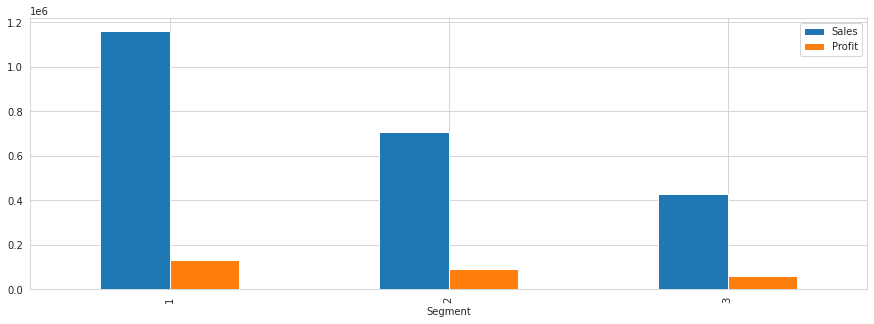

In [28]:
plt.figure()
superstore.groupby('Segment')[['Sales', 'Profit']].sum().plot(kind='bar', figsize=(15, 5))
plt.show()

## Andamento delle vendite nel tempo
Per prima cosa andiamo a convertire le date nel tipo corretto.

In [29]:
superstore['Ship Date']= pd.to_datetime(superstore['Ship Date'], format='%m/%d/%Y')

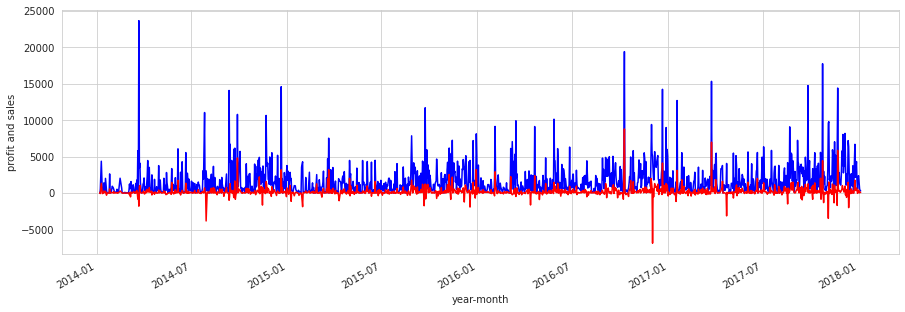

In [30]:
plt.figure(figsize=(15,5))
superstore.groupby('Ship Date')['Sales'].sum().plot(color='b')
superstore.groupby('Ship Date')['Profit'].sum().plot(color='r')
plt.xlabel('year-month')
plt.ylabel('profit and sales')
plt.show()

Il grafico rappresenta l'andamento dei prezzi di vendita e dei profitti dell'azienda per singola data di spedizione contenuta nel nostro dataset. Questo grafico permette di mettere in evidenza alcuni picchi locali ma non ci dà un'idea dell'andamento dell'azienda negli anni.

Proviamo a raggruppare i profitti e le vendite per mese e anno.

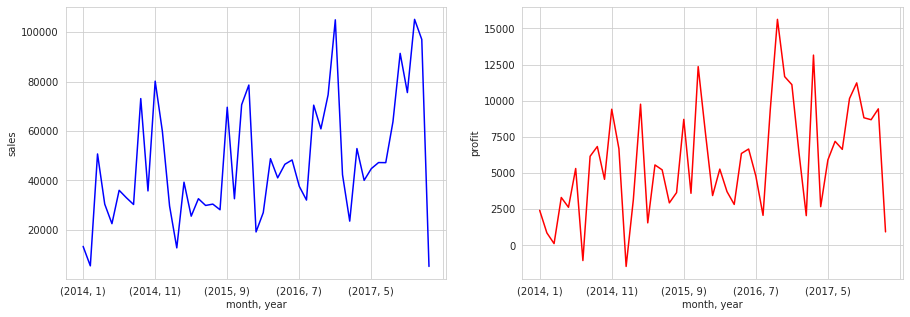

In [31]:
sales = superstore.groupby([superstore['Ship Date'].dt.year, superstore['Ship Date'].dt.month])['Sales']
profit = superstore.groupby([superstore['Ship Date'].dt.year, superstore['Ship Date'].dt.month])['Profit']

plt.figure(figsize=(15, 5))
plt.subplot(121)
sales.sum().plot(color='b')
plt.xlabel('month, year')
plt.ylabel('sales')

plt.subplot(122)
profit.sum().plot(color='r')
plt.xlabel('month, year')
plt.ylabel('profit')

plt.show()

Raggruppando profitti e vendite per anno e mese di spedizione riusciamo ad avere un'idea più precisa dell'andamento dell'azienda. Entrambi i grafici presentano molte oscillazioni, tendenzialmente le une in corrispondenza delle altre, tuttavia l'andamento generale risulta essere in crescita fino alla fine del 2017, dove si verifica una forte picco negativo sia dei prezzi di vendita, sia dei profitti.

Proviamo a visualizzare meglio i dati tramite un grafico a barre della somma dei profitti e dei prezzi di vendita raggruppati per anno.

<Figure size 432x288 with 0 Axes>

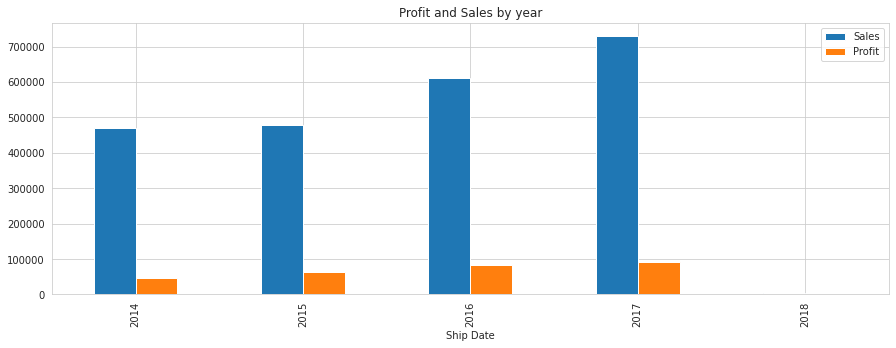

In [32]:
plt.figure()
superstore.groupby([superstore['Ship Date'].dt.year])[['Sales','Profit']].sum().plot(kind='bar', figsize=(15,5))
plt.title('Profit and Sales by year')
plt.show()

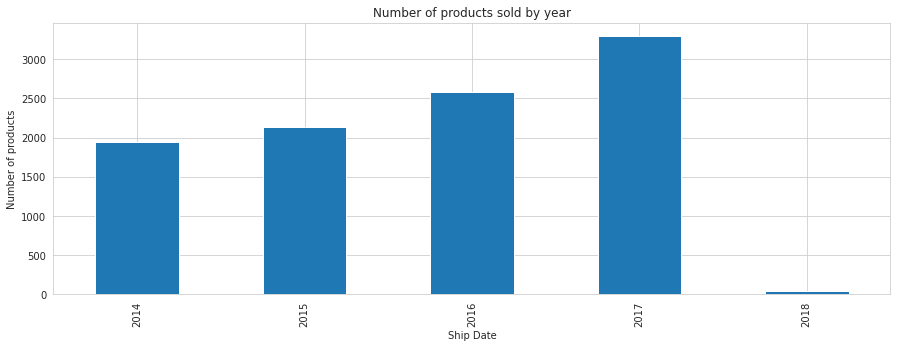

In [33]:
plt.figure()
superstore.groupby([superstore['Ship Date'].dt.year])['Sales'].count().plot(kind='bar', figsize=(15,5))
plt.title('Number of products sold by year')
plt.ylabel('Number of products')
plt.show()

L'andamento dell'azienda risulta essere effettivamente in crescita fino al 2017.
Per quanto riguarda il 2018 sono presenti pochi prodotti venduti e questo spiega le vendite e i profitti nulli in confronto agli altri anni.
Possiamo quindi andare a scartare le informazioni relative al 2018, confermando il trend di crescita del superstore.

## Conclusioni
Possiamo concludere ...